In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, Sequential



In [2]:
# Paths to your dataset directories
data_train_path = 'solid_dry_waste/train'
data_test_path = 'solid_dry_waste/test'
data_val_path = 'solid_dry_waste/validation'

In [3]:
# Image size and batch size
img_width =224 
img_height = 224 # Increase resolution for better feature extraction
batch_size = 32

In [4]:
# Load training dataset with augmentation
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 1500 files belonging to 3 classes.


In [5]:
# Class names
data_cat = data_train.class_names

In [6]:
# Load validation dataset
data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False
)



Found 300 files belonging to 3 classes.


In [7]:
# Load test dataset
data_test = tf.keras.utils.image_dataset_from_directory(
    data_test_path,
    image_size=(img_width, img_height),
    shuffle=False,
    batch_size=batch_size
)

Found 76 files belonging to 3 classes.


In [8]:
# Data preprocessing: prefetch and caching for faster I/O
AUTOTUNE = tf.data.AUTOTUNE
data_train = data_train.prefetch(buffer_size=AUTOTUNE)
data_val = data_val.prefetch(buffer_size=AUTOTUNE)
data_test = data_test.prefetch(buffer_size=AUTOTUNE)

In [9]:
# Data augmentation: Diversify training data
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

In [10]:
base_model = keras.applications.MobileNetV2(
    input_shape=(img_width, img_height, 3),
    include_top=False,
    weights='imagenet'
)

In [11]:
# Freeze the base model's layers to leverage pre-trained features
base_model.trainable = False

In [12]:
# Model architecture
model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_width, img_height, 3)),  # Normalize inputs
    data_augmentation,
    base_model,  # Add the pretrained model
    layers.GlobalAveragePooling2D(),  # Reduce dimensions before dense layers
    layers.Dropout(0.4),  # Increase dropout to further reduce overfitting
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),  # Additional dropout layer
    layers.Dense(len(data_cat), activation='softmax')  # Output layer
])

c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Start with a reasonable learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
# Early stopping and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [15]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

In [16]:
# TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [17]:
# Train the model
epochs_size = 30
history = model.fit(
    data_train,
    validation_data=data_val,
    epochs=epochs_size,
    callbacks=[early_stopping, reduce_lr, tensorboard_callback]
)

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5787 - loss: 3.0560 - val_accuracy: 0.9467 - val_loss: 1.7785 - learning_rate: 0.0010
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8289 - loss: 1.9230 - val_accuracy: 0.9533 - val_loss: 1.3003 - learning_rate: 0.0010
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8572 - loss: 1.4520 - val_accuracy: 0.9533 - val_loss: 1.0334 - learning_rate: 0.0010
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8694 - loss: 1.1814 - val_accuracy: 0.9600 - val_loss: 0.8159 - learning_rate: 0.0010
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9025 - loss: 0.9777 - val_accuracy: 0.9733 - val_loss: 0.6728 - learning_rate: 0.0010
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9082 - loss: 0.7865 - val_accuracy: 0.9700 - val_loss: 0.5704 - learning_rate: 0.0010
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9018 - loss: 0.7461 - val_accuracy: 

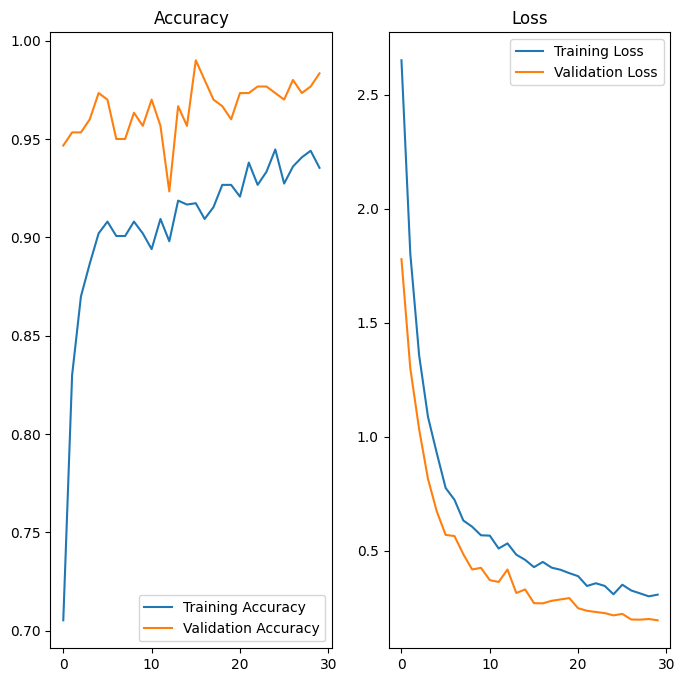

In [18]:
# Visualize training results
epochs_range = range(len(history.history['accuracy']))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [19]:
# Test with a single image
image_path = 'plasticBottle.jpg'
image = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
img_arr = tf.keras.utils.img_to_array(image)
img_bat = tf.expand_dims(img_arr, 0)  # Add batch dimension

In [20]:
# Prediction
predict = model.predict(img_bat)
score = tf.nn.softmax(predict[0])
print('Dry waste type in image is {} with confidence {:.2f}%'.format(data_cat[np.argmax(score)], np.max(score) * 100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Dry waste type in image is plastic bottle with confidence 57.57%


In [21]:
# Save the model
model.save('C:/Users/James/OneDrive/Desktop/EcoMend/Image_classify.keras', save_format='keras')